# 4. Badanie relacji między punktami

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
sns.set_theme(style="whitegrid")

### Dodanie przygotowanych poprzednio funkcji

In [2]:
def point_count_on_subregions(points, bins, x_lim, y_lim):
    hist = np.histogram2d(points["X"],points["Y"], bins,[x_lim,y_lim])
    hist = list(hist)
    hist[0] = hist[0].T

    return(hist)


def homogeneous_poisson_on_rectangle(intensity, x_lim, y_lim): 
    ExpValue = intensity*((x_lim[1]-x_lim[0])*(y_lim[1]-y_lim[0]))
    n = np.random.poisson(ExpValue)
    x = np.random.uniform(x_lim[0], x_lim[1], n)
    y = np.random.uniform(y_lim[0], y_lim[1], n)
    
    xx = x.flatten()
    yy = y.flatten()
    df_HP = pd.DataFrame(data = {"X": xx,"Y": yy})
    return df_HP


def regular_on_rectangle(grid, random_component, x_lim, y_lim):
    dx = (x_lim[1] - x_lim[0])/grid[0]
    dy = (y_lim[1] - y_lim[0])/grid[1]

    
    x = np.linspace((x_lim[0]+1/2*dx),(x_lim[1]-1/2*dx),grid[0])
    y = np.linspace((y_lim[0]+1/2*dy),(y_lim[1]-1/2*dy),grid[1])
    
    
    xx,yy = np.meshgrid(x,y)


    rand_xx = np.random.uniform(-1/2*dx,1/2*dx,size = (grid[1],grid[0]))*random_component
    rand_yy = np.random.uniform(-1/2*dy,1/2*dy,size = (grid[1],grid[0]))*random_component


    xx += rand_xx
    yy += rand_yy
    
    
    xx = xx.flatten()
    yy = yy.flatten()


    df_R = pd.DataFrame(data = {"X": xx,"Y": yy})
    
    return(df_R)


def materna_on_rectangle(parent_intensity, daughter_intensity, cluster_radius, x_lim, y_lim):
    xLimMinExt = x_lim[0] - cluster_radius
    xLimMaxExt = x_lim[1] + cluster_radius
    yLimMinExt = y_lim[0] - cluster_radius
    yLimMaxExt = y_lim[1] + cluster_radius
    
    
    areaTotalExt = (xLimMaxExt - xLimMinExt) * (yLimMaxExt - yLimMinExt)  

    numbPointsParent = np.random.poisson(areaTotalExt * parent_intensity)  

    
    xxParent = xLimMinExt + (xLimMaxExt - xLimMinExt) * np.random.uniform(0, 1, numbPointsParent)
    yyParent = yLimMinExt + (yLimMaxExt - yLimMinExt) * np.random.uniform(0, 1, numbPointsParent)

    numbPointsDaughter = np.random.poisson(daughter_intensity, numbPointsParent)
    numbPoints = sum(numbPointsDaughter)  


    theta = 2 * np.pi * np.random.uniform(0, 1, numbPoints)  
    gamma = cluster_radius * np.sqrt(np.random.uniform(0, 1, numbPoints))  
    
    xx0 = theta * np.cos(theta)
    yy0 = gamma * np.sin(gamma) 
    
    
    xx = np.repeat(xxParent, numbPointsDaughter)
    yy = np.repeat(yyParent, numbPointsDaughter)

    xx = xx + xx0
    yy = yy + yy0

    
    trimed = ((xx >= x_lim[0]) & (xx <= x_lim[1]) & (yy >= y_lim[0]) & (yy <= y_lim[1]))
    xx = xx[trimed]
    yy = yy[trimed]

    
    df_M = pd.DataFrame(data = {"X": xx,"Y": yy})
    
    return df_M

### Przygotowanie danych

Wygenerowano rozkłady punktowe o podanych paramatrach wykorzystując poprzednio przygotowane funkcje.

Jednorodny rozkład Poissona:
 - intensywność procesu: 2.5

Rozkład regularny z komponentem losowym:
- liczba punktów w poziomie i w pionie: 15x15
- komponent losowy: 0.75

Rozkład Materna:
 - intensywność procesu macierzystego: 0.3
 - intensywność procesu potomnego: 5
 - promień klastra: 0.75
 
Parametry identyczne dla wszystkich rozkładów:
 - zakres wartości współrzędnej x: [0, 10]
 - zakres wartości współrzędnej y: [0, 10]

In [3]:
df_HP = homogeneous_poisson_on_rectangle(2.5, [0,10], [0,10])
df_M  = materna_on_rectangle(0.3, 5, 0.75, [0,10], [0,10])
df_R = regular_on_rectangle((15,15),0.75,(0,10),(0,10))

### Wykres Morishity

Funkcja `morishita_plot_data()`, generuje dane niezbędne do wykonania wykresu Morishity. 

Wykorzystano przygotowaną funkcję do wygnenerowania danych dla wszystkich przygotowanych rozkładów punktów. Wykonano obliczenia dla obszaru podzielonego na 2x2, 3x3, ... 40x40 podobszarów w poziomie i w pionie.

Algorytm postępowania:
1. Kolejno podzielić obszar na rosnącą lub malejącą liczbę kwadratowych podobszarów.
2. Dla każdego z podziałów obliczyć wartość indeksu: <br/>
$MI = L \sum_{i=1}^L \frac{n_i (n_i-1)}{N(N-1)}$ <br/>
gdzie: $L$ - liczba podobszarów, $N$ - liczba punktów, $n_i$ - liczba punktów w obrębie i-tego podobszaru.
3. Zestawić w tabeli długości boków podobszarów w poszczególnych podziałach z obliczonymi dla nich wartości indeksu $MI$.

#### a) Przygotowanie funkcji

In [4]:
def morishita_plot_data(points, bins_list, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    bins_list: list
        Lista zawierająca wszystkie zestawy parametrów określających liczbę podobszarów w poziomie i pionie, dla których mają zostać przeprowadzone obliczenia.
        Przykład: [[2, 2], [4, 4], [8, 8], [16, 16]]
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10] 
    
    Returns
    -------
    morishita_index: DataFrame
        Tablica zawierająca dwie kolumny:
        - "BD" - długości boków podobszarów,
        - "MI" - wyliczone wartości indeksów MI.
    """

    N = len(points)
    MI = np.zeros(len(bins_list))
    BD = np.zeros(len(bins_list))
    
    for i in range(len(bins_list)):
        n,x,y = point_count_on_subregions(points, bins_list[i], x_lim, y_lim)
        L = (bins_list[i][0])*(bins_list[i][1])
        MI[i] = L*np.sum((n*(n-1))/(N*(N-1)))
        BD[i] = x_lim[1]/bins_list[i][0]
        
    morishita_index = pd.DataFrame(data = {"BD": BD, "MI": MI})
    
        
    return(morishita_index)

#### b) Wygenerowanie danych

In [5]:
x = np.arange(2,41,1)
y = np.arange(2,41,1)
df = pd.DataFrame(data = {"X": x,"Y": y})
bins_list = df.values.tolist()


Morishita_R = morishita_plot_data(df_R, bins_list, [0,10], [0,10])
Morishita_HP = morishita_plot_data(df_HP, bins_list, [0,10], [0,10])
Morishita_M = morishita_plot_data(df_M, bins_list, [0,10], [0,10])

#### c) Wizualizacja

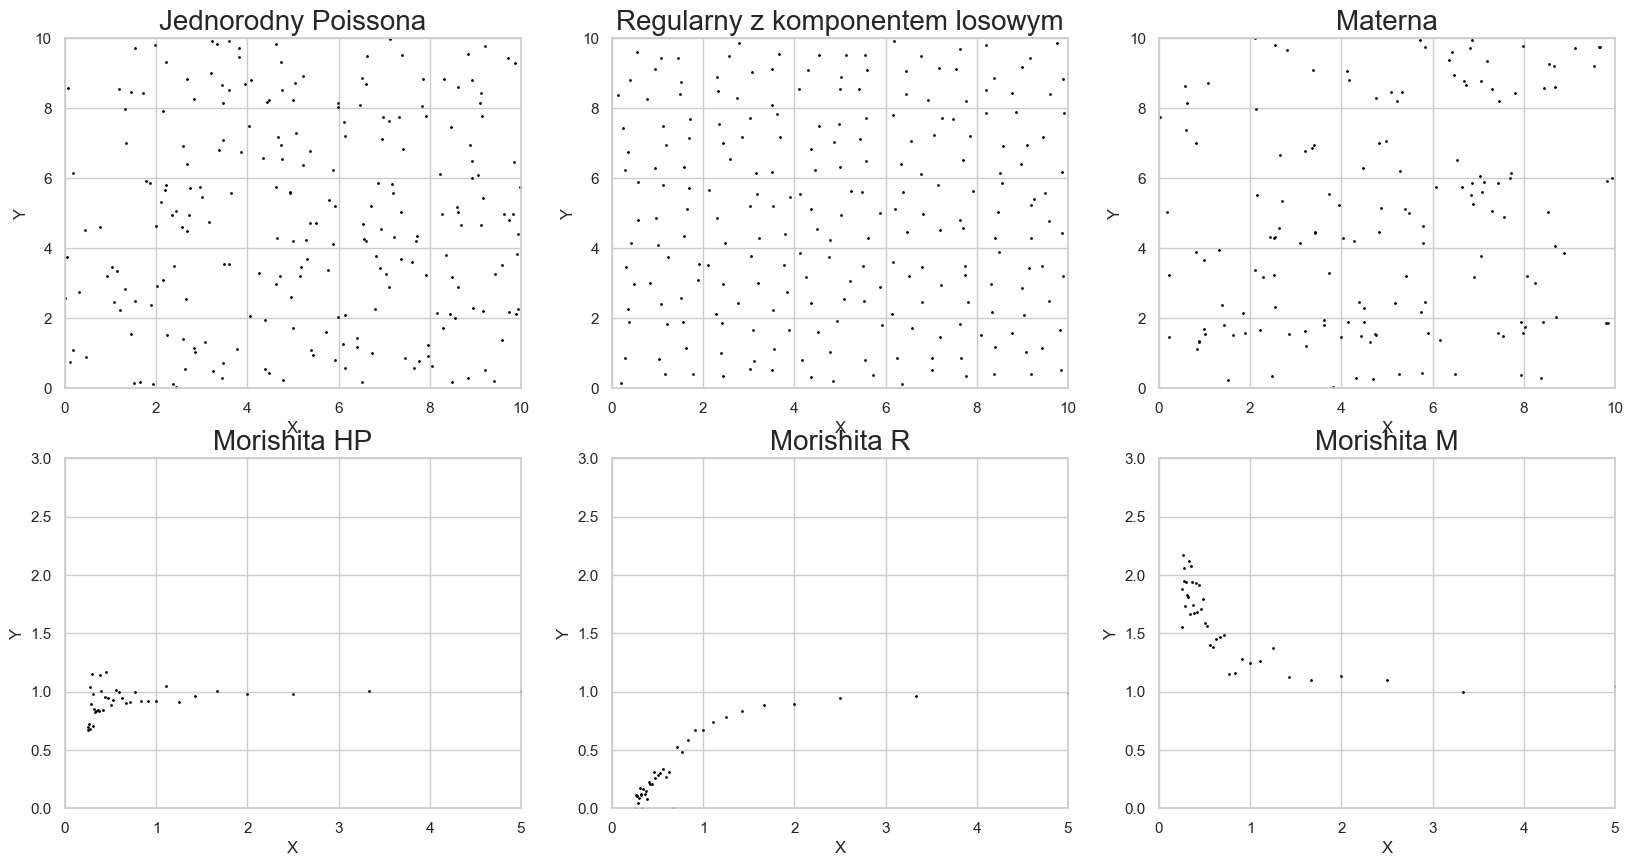

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))

axs[0,0].scatter(df_HP["X"],df_HP["Y"], s=1, c="black")
axs[1,0].scatter(Morishita_HP['BD'], Morishita_HP['MI'], s=1, c="black",norm="linear")
axs[0,0].set_title("Jednorodny Poissona", fontsize=20)
axs[1,0].set_title("Morishita HP", fontsize=20)

axs[0,1].scatter(df_R["X"],df_R["Y"], s=1, c="black")
axs[1,1].scatter(Morishita_R['BD'], Morishita_R['MI'], s=1, c="black")
axs[0,1].set_title("Regularny z komponentem losowym", fontsize=20)
axs[1,1].set_title("Morishita R", fontsize=20)

axs[0,2].scatter(df_M["X"],df_M["Y"], s=1, c="black")
axs[1,2].scatter(Morishita_M['BD'], Morishita_M['MI'], s=1, c="black",norm="log")
axs[0,2].set_title("Materna", fontsize=20)
axs[1,2].set_title("Morishita M", fontsize=20)

for i in range(3):
        axs[0,i].set_xlim([0, 10])
        axs[0,i].set_ylim([0, 10])
        axs[0,i].set_xlabel("X", fontsize = 12)
        axs[0,i].set_ylabel("Y", fontsize = 12)


for i in range(3):
        axs[1,i].set_xlim([0, 5])
        axs[1,i].set_ylim([0, 3])
        axs[1,i].set_xlabel("X", fontsize = 12)
        axs[1,i].set_ylabel("Y", fontsize = 12)

### Wykres Fry

Funkcja `fry_plot_data()`, generuje dane niezbędne do wykonania wykresu Morishity.

Wykorzystano przygotowaną funkcję do wygnenerowania danych dla wszystkich przygotowanych rozkładów punktów. 

Algorytm postępowania: <br/>
Traktując kolejno każdy punkt analizowanego rozkładu jako początek układu współrzędnych zapisać współrzędne pozostałych punktów względem niego.
Rezultatem jest zbiór współrzędnych $n(n-1)$ punktów, gdzie $n$ to liczba punktów w analizowanym rozkładzie.

#### a) Przygotowanie funkcji

In [7]:
def fry_plot_data(points):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    
    Returns
    -------
    fry_points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """    

    X_points = points["X"].tolist()
    Y_points = points["Y"].tolist()
    
    number_fry_points = len(X_points)*(len(X_points)-1)
    X = np.zeros(number_fry_points)
    Y = np.zeros(number_fry_points)

    k=0
    for i in range(len(X_points)):
        for j in range(len(X_points)):
            X_tmp = X_points[j] - X_points[i]
            Y_tmp = Y_points[j] - Y_points[i]
            
            if ((X_tmp != 0) and (Y_tmp != 0)):
                X[k] = X_tmp
                Y[k] = Y_tmp
                k = k + 1
    
                
    fry_points = pd.DataFrame(data = {"X": X, "Y": Y})
    
    return(fry_points)

#### b) Wygenerowanie danych

In [8]:
HP_fry_points = fry_plot_data(df_HP)
R_fry_points = fry_plot_data(df_R)
M_fry_points = fry_plot_data(df_M)

#### c) Wizualizacja

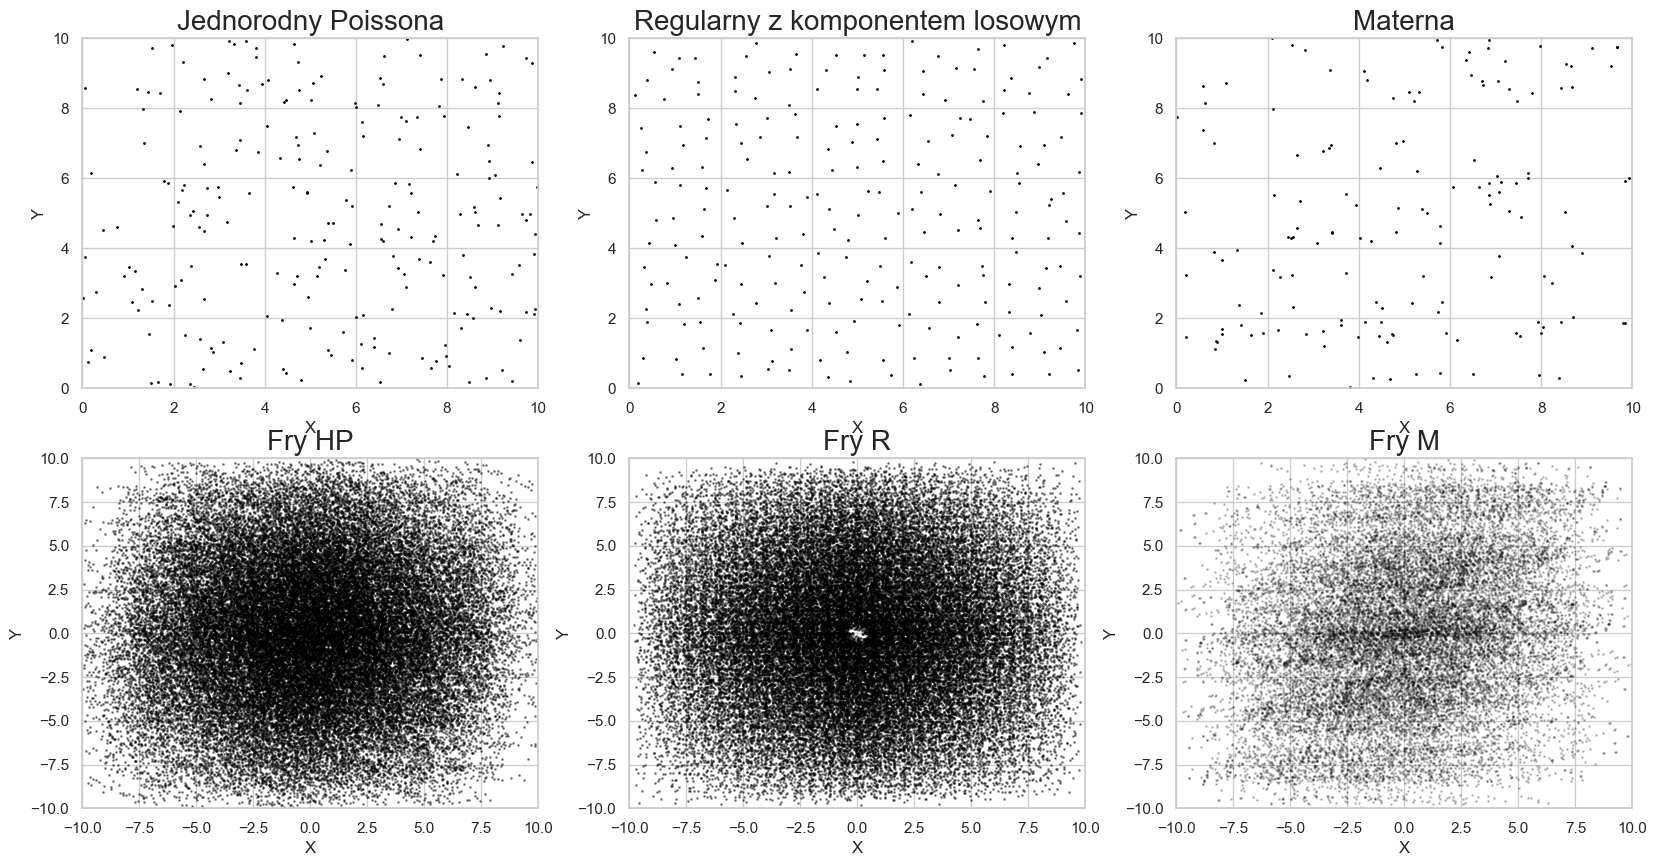

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))

axs[0,0].scatter(df_HP["X"],df_HP["Y"], s=1, c="black")
axs[1,0].scatter(HP_fry_points["X"],HP_fry_points["Y"], s=1, c="black", alpha=0.4)
axs[0,0].set_title("Jednorodny Poissona", fontsize=20)
axs[1,0].set_title("Fry HP", fontsize=20)

axs[0,1].scatter(df_R["X"],df_R["Y"], s=1, c="black")
axs[1,1].scatter(R_fry_points["X"],R_fry_points["Y"], s=1, c="black", alpha=0.4)
axs[0,1].set_title("Regularny z komponentem losowym", fontsize=20)
axs[1,1].set_title("Fry R", fontsize=20)

axs[0,2].scatter(df_M["X"],df_M["Y"], s=1, c="black")
axs[1,2].scatter(M_fry_points["X"],M_fry_points["Y"], s=1, c="black", alpha=0.2)
axs[0,2].set_title("Materna", fontsize=20)
axs[1,2].set_title("Fry M", fontsize=20)

for i in range(3):
        axs[0,i].set_xlim([0, 10])
        axs[0,i].set_ylim([0, 10])
        axs[0,i].set_xlabel("X", fontsize = 12)
        axs[0,i].set_ylabel("Y", fontsize = 12)

for i in range(3):
        axs[1,i].set_xlim([-10, 10])
        axs[1,i].set_ylim([-10, 10])
        axs[1,i].set_xlabel("X", fontsize = 12)
        axs[1,i].set_ylabel("Y", fontsize = 12)